Generation 0: Best Cost So Far: 62480.50463165376
Generation 1000: Best Cost So Far: 62480.50463165376
Generation 2000: Best Cost So Far: 61622.22006865558
Generation 3000: Best Cost So Far: 60944.44109841175
Generation 4000: Best Cost So Far: 60366.58962148852
Generation 5000: Best Cost So Far: 59305.50298939021
Generation 6000: Best Cost So Far: 59055.163456058865
Generation 7000: Best Cost So Far: 58769.94278119875
Generation 8000: Best Cost So Far: 58609.84151201312
Generation 9000: Best Cost So Far: 58303.96154475883
Generation 10000: Best Cost So Far: 57459.05705944808
Generation 11000: Best Cost So Far: 57220.138705554455
Generation 12000: Best Cost So Far: 57034.925968908996
Generation 13000: Best Cost So Far: 56233.64029266205
Generation 14000: Best Cost So Far: 55585.73761931277
Generation 15000: Best Cost So Far: 55193.44445852845
Generation 16000: Best Cost So Far: 55184.82215088737
Generation 17000: Best Cost So Far: 55140.64300596261
Generation 18000: Best Cost So Far: 55

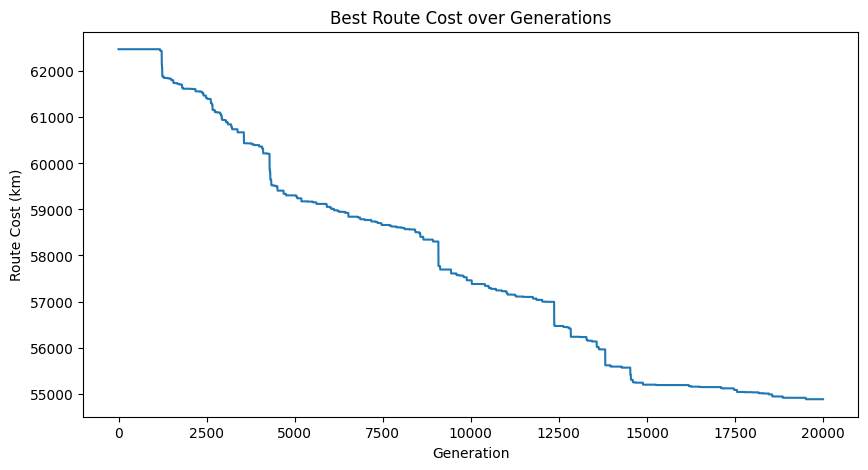

Best Route: ['Acheng', 'Harbin', 'Zhaoyuan', 'Songyuan', 'Qianguo', 'Qianan', 'Baicheng', 'Ulanhot', 'Taonan', 'Tongliao', 'Shuangliao', 'Tiefa', 'Tieling', 'Fushun', 'Dongling', 'Yuhong', 'Shenyang', 'Sujiatun', 'Dengta', 'Liaoyang', 'Benxi', 'Tonghua', 'Baishan', 'Linjiang', 'Fengcheng', 'Dandong', 'Donggang', 'Zhuanghe', 'Dalian', 'Pulandian', 'Wafangdian', 'Gaizhou', 'Dashiqiao', 'Yingkou', 'Panjin', 'Jiupu', 'Anshan', 'Liaozhong', 'Xinmin', 'Beining', 'Fuxin', 'Beipiao', 'Chaoyang', 'Linghai', 'Jinzhou', 'Huludao', 'Xingcheng', 'Qinhuangdao', 'Zunhua', 'Chengde', 'Lingyuan', 'Chifeng', 'Xilinhot', 'Zhangjiakou', 'Changping', 'Shunyi', 'Sanhe', 'Yanjiao', 'Tongzhou', 'Beijing', 'Mentougou', 'Fangshan', 'Zhuozhou', 'Gaobeidian', 'Baoding', 'Anguo', 'Dingzhou', 'Xinle', 'Luquan', 'Shijiazhuang', 'Luancheng', 'Gaocheng', 'Xinji', 'Shenzhou', 'Hengshui', 'Jizhou', 'Nangong', 'Xingtai', 'Shahe', 'Wuan', 'Linshui', 'Hebi', 'Huixian', 'Jiaozuo', 'Qinyang', 'Mengzhou', 'Yanshi', 'Xiaoyi', 

In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations
from geopy.distance import geodesic
import random
import matplotlib.pyplot as plt

# Load cities data
CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])

# Create distance matrix
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

def tsp_cost(tsp):
    """Calculate total cost of a TSP route."""
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))
    
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

class GeneticTSPSolver:
    def __init__(self, population_size=200, max_generations=20000, 
                 mutation_rate=0.2, elitism_ratio=0.1):
        """
        Initialize Genetic Algorithm for TSP
        
        Parameters:
        - population_size: Number of routes in each generation
        - max_generations: Maximum number of evolutionary iterations
        - mutation_rate: Probability of random mutation
        - elitism_ratio: Percentage of best routes preserved between generations
        """
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_ratio = elitism_ratio
        self.n_cities = len(CITIES)

    def create_greedy_route(self, start_city=0):
        """Create a greedy route starting from a given city."""
        route = [start_city]
        unvisited = set(range(self.n_cities)) - {start_city}
        
        while unvisited:
            last_city = route[-1]
            nearest = min(unvisited, key=lambda city: DIST_MATRIX[last_city, city])
            route.append(nearest)
            unvisited.remove(nearest)
        
        route.append(start_city)  # Complete the tour
        return route

    def initialize_population(self):
        """
        Create initial population with a mix of greedy and random routes
        """
        population = []
        
        # Add multiple greedy routes starting from different cities
        num_greedy_routes = int(self.population_size * 0.1)
        for start_city in range(num_greedy_routes):
            population.append(self.create_greedy_route(start_city=start_city))
        
        # Generate remaining random routes
        while len(population) < self.population_size:
            route = list(range(1, self.n_cities))
            random.shuffle(route)
            route = [0] + route + [0]  # Complete the tour
            population.append(route)
        
        return population
    
    def roulette_wheel_selection(self, fitness):
        """Select an individual based on roulette wheel selection"""
        total_fitness = sum(fitness)
        pick = random.uniform(0, total_fitness)
        current = 0
        for i, fit in enumerate(fitness):
            current += fit
            if current >= pick:
                return i

    def crossover(self, parent1, parent2):
        """Partially Mapped Crossover (PMX) for TSP ensuring valid child"""
        start, end = sorted(random.sample(range(1, self.n_cities), 2))
        
        child = [-1] * (self.n_cities + 1)
        child[0] = child[-1] = 0  # Start and end at the initial city
        
        # Copy subset from parent1
        child[start:end+1] = parent1[start:end+1]
        
        # Fill remaining positions from parent2
        for i in range(1, self.n_cities):
            if i < start or i > end:
                city = parent2[i]
                while city in child[start:end+1]:
                    city_index = parent1.index(city)
                    city = parent2[city_index]
                child[i] = city

        # Ensure no missing cities in the child
        missing_cities = set(range(1, self.n_cities)) - set(child[1:-1])
        for i in range(1, self.n_cities):
            if child[i] == -1:
                child[i] = missing_cities.pop()
        
        return child
    

    """
    #original function that swaps 2 cities in the route
    def mutate(self, route):
        #Inversion mutation: reverse a sub-route
        if random.random() < self.mutation_rate:
            i, j = sorted(random.sample(range(1, self.n_cities), 2))
            route[i:j+1] = reversed(route[i:j+1])
        return route
    """

    """
    def mutate(self, route):
        
        #Inversion mutation: randomly selects two points in the route and reverses the segment.
        #This helps to explore different paths effectively for the TSP.
        
        if random.random() < self.mutation_rate:
            # Choose two points for inversion
            i, j = sorted(random.sample(range(1, self.n_cities), 2))
            # Reverse the segment between the two points
            route[i:j+1] = reversed(route[i:j+1])
        return route
    """

    def mutate(self, route):
        
        if random.random() < self.mutation_rate:
            # Inversion mutation
            i, j = sorted(random.sample(range(1, self.n_cities), 2))
            route[i:j+1] = reversed(route[i:j+1])
    
        # Optionally apply an insertion mutation with a small chance
        if random.random() < self.mutation_rate / 2:
            # Select a city and insert it at a different position
            i, j = random.sample(range(1, self.n_cities), 2)
            city = route.pop(i)
            route.insert(j, city)
        
        return route

    

    def solve(self):
        """Main evolutionary algorithm solving method with sanity check"""
        population = self.initialize_population()
        
        # Sanity check for initial population
        population = [route for route in population if len(set(route)) == self.n_cities and route[0] == route[-1]]
        
        best_costs = []
        best_overall_route = None
        best_overall_cost = float('inf')
        
        for generation in range(self.max_generations):
            # Evaluate fitness (lower cost is better)
            fitness = []
            for route in population:
                try:
                    cost = tsp_cost(route)
                    fitness.append(1 / cost)
                except AssertionError as e:
                    print(f"Invalid route detected: {route}. Error: {e}")
            
            if not fitness:
                raise RuntimeError("All routes are invalid. Check initialization or crossover logic.")
            
            # Track best route
            best_route_index = np.argmax(fitness)
            current_best_route = population[best_route_index]
            current_best_cost = tsp_cost(current_best_route)
            
            # Update overall best
            if current_best_cost < best_overall_cost:
                best_overall_route = current_best_route
                best_overall_cost = current_best_cost
            
            best_costs.append(current_best_cost)

             # Print update every 1000 generations
            if generation % 1000 == 0:
                print(f"Generation {generation}: Best Cost So Far: {best_overall_cost}")
            
            # Select parents and apply elitism
            new_population = []
            elite_count = int(self.population_size * self.elitism_ratio)
            elite_indices = np.argsort(fitness)[-elite_count:]
            new_population.extend([population[i] for i in elite_indices])
            
            # Generate offspring
            while len(new_population) < self.population_size:
                parent1 = population[self.roulette_wheel_selection(fitness)]
                parent2 = population[self.roulette_wheel_selection(fitness)]
                
                # Crossover
                child = self.crossover(parent1, parent2)
                
                # Mutation
                child = self.mutate(child)
                
                # Verify child validity and add to population
                if len(set(child)) == self.n_cities and child[0] == child[-1]:
                    new_population.append(child)
            
            population = new_population
        
        # Plot convergence
        plt.figure(figsize=(10, 5))
        plt.plot(best_costs)
        plt.title('Best Route Cost over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Route Cost (km)')
        plt.show()
        
        return best_overall_route, best_overall_cost





# main
solver = GeneticTSPSolver()
best_route, best_cost = solver.solve()

# Print results
print("Best Route:", [CITIES.loc[i, 'name'] for i in best_route])
print(f"Total Distance: {best_cost:.2f} km")

